In [1]:
# === Bibliotecas padrão ===
from pathlib import Path
import importlib

# === Bibliotecas de terceiros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from scipy.stats import chi2_contingency

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report,
    mean_absolute_error, mean_squared_error, r2_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import compute_sample_weight

import joblib

# === Módulos locais ===
import sys
import os

# Caminho absoluto até a pasta src
src_path = Path.cwd().parent / "notebooks" / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    
# Agora importa diretamente SEM prefixo
import leadscore_plot

from leadscore_plot import (
    plot_comparativo_leads_alunos,
    plot_histograma_leadscore,
    plot_probabilidade_conversao_vs_score
)

# === Configuração de visualização ===
cores = plt.get_cmap('Accent').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
dados_path = Path.cwd().parent / "dados"
df_leads = pd.read_parquet(dados_path / "leads.parquet")
df_alunos = pd.read_parquet(dados_path / "alunos.parquet")

In [3]:
df_leads.drop(columns=['email', 'whatsapp']).head()

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,comprou,utm_source,utm_medium,utm_campaign,utm_content,utm_term
0,2025-01-27 17:31:57,L32,SP,26 - 35 anos,médio completo,de 3.000 a 5.000,união estável,sim,sonho de criança,falta de base escolar,0,whatsapp,grupos antigos,l32,None,None
1,2024-11-20 10:56:47,L31,SP,46 - 55 anos,médio completo,até 1.000,divorciado(a) ou separado(a),sim,gosta da profissão,falta de oportunidade,0,instagram_feed,04_ll_1_envolvimento_30d,l31,video_vemai_v1,frio
2,2025-01-28 01:45:29,L32,SP,26 - 35 anos,fundamental completo,desempregado,solteiro(a),não,sonho de criança,financeiro / dinheiro,0,tva,04_afinidade_luta,l32,video_5_motivos_yt,None
3,2025-03-17 20:27:57,L33,SP,26 - 35 anos,médio completo,desempregado,solteiro(a),sim,sonho de criança,financeiro / dinheiro,0,instagram,bio,l33,None,None
4,2025-03-23 22:39:51,L33,SP,26 - 35 anos,médio completo,de 1.000 a 3.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,0,instagram_stories,04_ll_10_lista_de_alunos,l33,video_vemai_v1_pag_f,frio


In [4]:
df_leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12730 entries, 0 to 12729
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                12730 non-null  datetime64[ns]
 1   lancamentos         12730 non-null  object        
 2   email               12730 non-null  object        
 3   whatsapp            12728 non-null  object        
 4   estado              12730 non-null  object        
 5   idade               12730 non-null  object        
 6   escolaridade        12730 non-null  object        
 7   renda               12730 non-null  object        
 8   estado_civil        12730 non-null  object        
 9   filhos              12730 non-null  object        
 10  escolheu_profissao  12730 non-null  object        
 11  dificuldade         12730 non-null  object        
 12  comprou             12730 non-null  int32         
 13  utm_source          12683 non-null  object    

In [5]:
df_alunos.drop(columns=['email', 'whatsapp']).head()

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,comprou,utm_source,utm_medium,utm_campaign,utm_content,utm_term
0,2025-03-21 11:38:46,L33,SP,46 - 55 anos,superior completo,desempregado,casado(a),não,gosta da profissão,idade,1,tva,00_envolvimento_yt_180d,l33,video_caminhoneiro_yt,None
1,2025-01-28 18:52:59,L32,SP,até 25 anos,médio completo,de 1.000 a 3.000,casado(a),não,sonho de criança,idade,1,instagram,manychat,l32,None,None
2,2025-01-20 08:28:02,L32,RJ,36 - 45 anos,superior completo,de 1.000 a 3.000,casado(a),não,gosta da profissão,falta de tempo,1,tva,04_mercado_concurso,l32,video_entrevista_v2_yt,None
3,2025-02-03 13:50:29,L32,SP,46 - 55 anos,médio completo,de 3.000 a 5.000,casado(a),sim,gosta da profissão,falta de tempo,1,instagram_feed,00_envolvimento_60d_seguidores,l32,video_entrevista_v2,quente
4,2025-01-31 11:07:23,L32,SP,36 - 45 anos,médio completo,de 3.000 a 5.000,solteiro(a),não,gosta da profissão,financeiro / dinheiro,1,whatsapp,grupos antigos,l32,None,None


In [6]:
df_alunos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data                189 non-null    datetime64[ns]
 1   lancamentos         189 non-null    object        
 2   email               189 non-null    object        
 3   whatsapp            189 non-null    object        
 4   estado              189 non-null    object        
 5   idade               189 non-null    object        
 6   escolaridade        189 non-null    object        
 7   renda               189 non-null    object        
 8   estado_civil        189 non-null    object        
 9   filhos              189 non-null    object        
 10  escolheu_profissao  189 non-null    object        
 11  dificuldade         189 non-null    object        
 12  comprou             189 non-null    int32         
 13  utm_source          189 non-null    object        

In [7]:
for col in df_leads.select_dtypes(include=["object"]).columns:
    if col not in ["data", "email", "whatsapp"]:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_leads[col].value_counts(dropna=False))


====== VARIÁVEL: LANCAMENTOS ======

lancamentos
L32    4682
L34    3182
L31    2528
L33    2338
Name: count, dtype: int64

====== VARIÁVEL: ESTADO ======

estado
SP       8685
RJ       1484
MG       1243
Outro     976
PR        205
MA         27
MS         26
BA         22
RS         16
PE         11
GO          8
AL          7
SC          6
CE          4
DF          2
PA          2
ES          2
RR          1
AC          1
TO          1
RN          1
Name: count, dtype: int64

====== VARIÁVEL: IDADE ======

idade
36 - 45 anos        4953
26 - 35 anos        3875
46 - 55 anos        2817
até 25 anos          857
acima de 56 anos     228
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ======

escolaridade
médio completo            9399
superior completo         2227
fundamental completo      1005
superior incompleto         68
técnico                     18
médio incompleto             7
fundamental incompleto       6
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======



In [8]:
colunas_excluir = ["data", "email", "whatsapp"]

for col in df_alunos.select_dtypes(include=["category", "object"]).columns:
    if col not in colunas_excluir:
        print(f"\n====== VARIÁVEL: {col.upper()} ======\n")
        print(df_alunos[col].value_counts(dropna=False))


====== VARIÁVEL: LANCAMENTOS ======

lancamentos
L32    84
L31    61
L33    44
Name: count, dtype: int64

====== VARIÁVEL: ESTADO ======

estado
SP    169
RJ     12
MG      7
DF      1
Name: count, dtype: int64

====== VARIÁVEL: IDADE ======

idade
36 - 45 anos        69
26 - 35 anos        60
46 - 55 anos        44
até 25 anos         13
acima de 56 anos     3
Name: count, dtype: int64

====== VARIÁVEL: ESCOLARIDADE ======

escolaridade
médio completo          132
superior completo        42
fundamental completo      9
superior incompleto       4
técnico                   2
Name: count, dtype: int64

====== VARIÁVEL: RENDA ======

renda
de 1.000 a 3.000    99
de 3.000 a 5.000    51
desempregado        18
acima de 5.000      14
até 1.000            7
Name: count, dtype: int64

====== VARIÁVEL: ESTADO_CIVIL ======

estado_civil
casado(a)                       89
solteiro(a)                     67
união estável                   19
divorciado(a) ou separado(a)    14
Name: count, dtype: 

In [9]:
def gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col, col_lancamento="lancamentos", min_leads=5):
    """
    Calcula lift por categoria com base em lançamentos,
    usando médias ponderadas e sem warnings futuros.
    """

    # Padroniza e remove nulos reais e disfarçados
    def limpar_coluna(df):
        return df[df[col].notna() & ~df[col].astype(str).str.strip().isin(["", "nan", "NaN", "None"])]

    df_leads = limpar_coluna(df_leads)
    df_alunos = limpar_coluna(df_alunos)
    
    ciclos = pd.Index(df_alunos[col_lancamento].dropna().unique()).union(
        df_leads[col_lancamento].dropna().unique()
    )

    linhas = []

    for ciclo in ciclos:
        leads_ciclo = df_leads[df_leads[col_lancamento] == ciclo]
        alunos_ciclo = df_alunos[df_alunos[col_lancamento] == ciclo]

        cont_leads = leads_ciclo[col].value_counts().rename("qtd_leads")
        cont_alunos = alunos_ciclo[col].value_counts().rename("qtd_alunos")

        total_leads = cont_leads.sum()
        total_alunos = cont_alunos.sum()

        perc_leads = (cont_leads / total_leads * 100).rename("percentual_leads")
        perc_alunos = (cont_alunos / total_alunos * 100).rename("percentual_alunos")

        tabela = pd.concat([cont_leads, cont_alunos, perc_leads, perc_alunos], axis=1).fillna(0)
        tabela["lancamento"] = ciclo
        tabela.reset_index(inplace=True)
        tabela.rename(columns={"index": col}, inplace=True)

        tabela_validas = tabela[tabela["qtd_leads"] >= min_leads].copy()
        tabela_validas["lift"] = tabela_validas.apply(
            lambda row: row["percentual_alunos"] / row["percentual_leads"] if row["percentual_leads"] > 0 else 0,
            axis=1
        )
        tabela_validas["score"] = (tabela_validas["lift"] * tabela_validas["qtd_alunos"]).round(2)
        linhas.append(tabela_validas)

    df_validado = pd.concat(linhas, ignore_index=True)

    # Primeiro faz o groupby
    agrupado = df_validado.groupby(col, observed=True)

    # Depois aplica manualmente
    resultados = []
    for categoria, grupo in agrupado:
        qtd_leads = grupo["qtd_leads"].sum()
        qtd_alunos = grupo["qtd_alunos"].sum()
        percentual_leads = (grupo["percentual_leads"] * grupo["qtd_leads"]).sum() / grupo["qtd_leads"].sum()
        percentual_alunos = (grupo["percentual_alunos"] * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0
        lift_vals = grupo["lift"].replace([np.inf, -np.inf], 0)
        lift = (lift_vals * grupo["qtd_alunos"]).sum() / grupo["qtd_alunos"].sum() if grupo["qtd_alunos"].sum() > 0 else 0

        score_vals = grupo["score"].replace([np.inf, -np.inf], 0)
        score = score_vals.sum()

        resultados.append({
            col: categoria,
            "qtd_leads": round(qtd_leads, 2),
            "qtd_alunos": round(qtd_alunos, 2),
            "percentual_leads": round(percentual_leads, 2),
            "percentual_alunos": round(percentual_alunos, 2),
            "lift": round(lift, 2),
            "score": round(score, 2)
        })

    tabela_final = pd.DataFrame(resultados).set_index(col)

    # Anotação
    todas_categorias = set(df_leads[col].dropna().unique()).union(set(df_alunos[col].dropna().unique()))
    categorias_na_tabela = set(tabela_final.index)
    categorias_descartadas = todas_categorias - categorias_na_tabela

    return tabela_final.sort_values(by="score", ascending=False)

In [10]:
# Lista das colunas a serem avaliadas
features_alunos = [
    "estado",
    "renda",
    "escolaridade",
    "idade",
    "filhos",
    "estado_civil",
    "escolheu_profissao"
]

for coluna in features_alunos:
    print(f"\n=== TABELA: {coluna} ===")
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, coluna)

    # Colunas a somar (ignorando 'lift' e 'score')
    colunas_para_somar = [
        col for col in tabela.columns
        if col not in ["lift", "score", "percentual_alunos", "percentual_leads"]
        and pd.api.types.is_numeric_dtype(tabela[col])
    ]

    # Criar linha de total
    totais = tabela[colunas_para_somar].sum().to_frame().T
    totais.index = ["Total"]

    # Preencher colunas restantes com vazio ou marcador
    for col in tabela.columns:
        if col not in totais.columns:
            totais[col] = "-"

    # Reordenar para manter consistência
    totais = totais[tabela.columns]

    # Concatenar com a tabela original
    tabela_com_total = pd.concat([tabela, totais], axis=0)

    display(tabela_com_total)


=== TABELA: estado ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
SP,8685.0,169.0,70.16,89.47,1.2,202.12
RJ,1484.0,12.0,13.86,7.55,0.49,5.85
MG,1243.0,7.0,9.86,4.75,0.54,3.75
AL,6.0,0.0,0.19,0.0,0.0,0.0
BA,21.0,0.0,0.41,0.0,0.0,0.0
MA,20.0,0.0,0.63,0.0,0.0,0.0
MS,24.0,0.0,0.34,0.0,0.0,0.0
Outro,976.0,0.0,30.67,0.0,0.0,0.0
PE,10.0,0.0,0.31,0.0,0.0,0.0
PR,205.0,0.0,4.4,0.0,0.0,0.0



=== TABELA: renda ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
de 1.000 a 3.000,6666.0,99.0,52.37,52.88,1.01,99.95
de 3.000 a 5.000,3026.0,51.0,23.78,27.28,1.15,58.73
desempregado,985.0,18.0,7.75,10.66,1.39,25.09
acima de 5.000,917.0,14.0,7.25,7.82,1.11,15.57
até 1.000,1136.0,7.0,8.94,4.81,0.55,3.88
Total,12730.0,189.0,-,-,-,-



=== TABELA: escolaridade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
médio completo,9399.0,132.0,73.84,70.57,0.96,126.24
superior completo,2227.0,42.0,17.53,23.87,1.39,58.25
superior incompleto,68.0,4.0,0.56,2.83,4.73,18.94
fundamental completo,1005.0,9.0,8.03,5.2,0.72,6.49
técnico,11.0,1.0,0.23,1.19,5.07,5.07
fundamental incompleto,5.0,0.0,0.11,0.0,0.0,0.0
Total,12715.0,188.0,-,-,-,-



=== TABELA: idade ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
36 - 45 anos,4953.0,69.0,38.94,37.59,0.99,68.2
26 - 35 anos,3875.0,60.0,30.53,31.96,1.05,62.71
46 - 55 anos,2817.0,44.0,22.57,24.84,1.22,53.7
até 25 anos,857.0,13.0,6.94,7.2,1.07,13.96
acima de 56 anos,228.0,3.0,1.88,2.94,1.4,4.21
Total,12730.0,189.0,-,-,-,-



=== TABELA: filhos ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
sim,9214.0,126.0,72.39,66.73,0.93,116.95
não,3516.0,63.0,27.65,33.46,1.19,74.97
Total,12730.0,189.0,-,-,-,-



=== TABELA: estado_civil ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
casado(a),4862.0,89.0,38.22,47.72,1.26,112.39
solteiro(a),5083.0,67.0,39.97,35.71,0.89,59.33
união estável,1262.0,19.0,9.94,10.51,1.08,20.48
divorciado(a) ou separado(a),1513.0,14.0,11.96,8.06,0.68,9.51
viúvo(a),6.0,0.0,0.13,0.0,0.0,0.0
Total,12726.0,189.0,-,-,-,-



=== TABELA: escolheu_profissao ===


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos,lift,score
sonho de criança,4413.0,71.0,34.71,37.72,1.08,76.68
gosta da profissão,4496.0,70.0,35.32,37.11,1.05,73.77
prestígio da carreira,1187.0,20.0,9.33,10.84,1.16,23.13
estabilidade de emprego,2555.0,27.0,20.11,14.79,0.73,19.59
segurança,79.0,1.0,0.67,1.64,3.19,3.19
Total,12730.0,189.0,-,-,-,-


In [11]:
# Função auxiliar para listar valores únicos, já aplicando strip
def listar_valores_unicos(df, coluna):
    return sorted({str(v).strip() for v in df[coluna].dropna().unique()})

# Loop pelas variáveis
for coluna in features_alunos:
    print(f"\n\n=== VARIÁVEL: {coluna.upper()} ===")

    valores_leads = listar_valores_unicos(df_leads, coluna)
    valores_alunos = listar_valores_unicos(df_alunos, coluna)

    print("\n🎯 Valores em df_leads:")
    for v in valores_leads:
        print(f"- '{v}'")

    print("\n🎯 Valores em df_alunos:")
    for v in valores_alunos:
        print(f"- '{v}'")

    print("\n🚨 Categorias nos leads mas não nos alunos:")
    diferenca_leads = set(valores_leads) - set(valores_alunos)
    print(diferenca_leads if diferenca_leads else "Nenhuma diferença.")

    print("\n🚨 Categorias nos alunos mas não nos leads:")
    diferenca_alunos = set(valores_alunos) - set(valores_leads)
    print(diferenca_alunos if diferenca_alunos else "Nenhuma diferença.")



=== VARIÁVEL: ESTADO ===

🎯 Valores em df_leads:
- 'AC'
- 'AL'
- 'BA'
- 'CE'
- 'DF'
- 'ES'
- 'GO'
- 'MA'
- 'MG'
- 'MS'
- 'Outro'
- 'PA'
- 'PE'
- 'PR'
- 'RJ'
- 'RN'
- 'RR'
- 'RS'
- 'SC'
- 'SP'
- 'TO'

🎯 Valores em df_alunos:
- 'DF'
- 'MG'
- 'RJ'
- 'SP'

🚨 Categorias nos leads mas não nos alunos:
{'SC', 'MS', 'MA', 'BA', 'RR', 'Outro', 'CE', 'ES', 'PA', 'GO', 'AL', 'PR', 'PE', 'TO', 'AC', 'RS', 'RN'}

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: RENDA ===

🎯 Valores em df_leads:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'

🎯 Valores em df_alunos:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'

🚨 Categorias nos leads mas não nos alunos:
Nenhuma diferença.

🚨 Categorias nos alunos mas não nos leads:
Nenhuma diferença.


=== VARIÁVEL: ESCOLARIDADE ===

🎯 Valores em df_leads:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'médio incompleto'

In [12]:
def gerar_distribuicao_por_categoria(df_leads, df_alunos, col):
    """
    Gera a tabela com contagem e percentual de leads e alunos por categoria, sem lift ou score.

    Retorno:
    -------
    pd.DataFrame com colunas: categoria, qtd_leads, qtd_alunos, percentual_leads, percentual_alunos
    """
    contagem_leads = df_leads[col].value_counts().rename("qtd_leads")
    contagem_alunos = df_alunos[col].value_counts().rename("qtd_alunos")

    percentual_leads = (contagem_leads / contagem_leads.sum() * 100).round(2).rename("percentual_leads")
    percentual_alunos = (contagem_alunos / contagem_alunos.sum() * 100).round(2).rename("percentual_alunos")

    tabela = pd.concat([contagem_leads, contagem_alunos, percentual_leads, percentual_alunos], axis=1).fillna(0)
    tabela = tabela.astype({"qtd_leads": int, "qtd_alunos": int})
    return tabela

In [13]:
for coluna in features_alunos:
    print(f"\n====== VARIÁVEL: {coluna.upper()} ======\n")

    for lanc in sorted(df_leads["lancamentos"].dropna().unique()):
        print(f"\n--- Lançamento: {lanc} ---")
        
        leads_subset = df_leads[df_leads["lancamentos"] == lanc]
        alunos_subset = df_alunos[df_alunos["lancamentos"] == lanc]

        if not leads_subset.empty and not alunos_subset.empty:
            tabela = gerar_distribuicao_por_categoria(leads_subset, alunos_subset, coluna)
            display(tabela)
        else:
            print("⚠️ Dados insuficientes para este lançamento.")


====== VARIÁVEL: ESTADO ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado,,,,
SP,1909,54,75.51,88.52
RJ,383,3,15.15,4.92
MG,217,4,8.58,6.56
PR,9,0,0.36,0.00
GO,4,0,0.16,0.00
MA,3,0,0.12,0.00
MS,2,0,0.08,0.00
BA,1,0,0.04,0.00



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado,,,,
SP,3571,77,76.27,91.67
RJ,612,4,13.07,4.76
MG,443,2,9.46,2.38
PR,19,0,0.41,0.00
MS,17,0,0.36,0.00
BA,5,0,0.11,0.00
MA,3,0,0.06,0.00
RS,2,0,0.04,0.00
SC,2,0,0.04,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado,,,,
SP,1658,38,70.92,86.36
RJ,388,5,16.60,11.36
MG,273,1,11.68,2.27
PR,9,0,0.38,0.00
MS,7,0,0.30,0.00
GO,1,0,0.04,0.00
MA,1,0,0.04,0.00
RS,1,0,0.04,0.00



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: RENDA ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,1314,36,51.98,59.02
de 3.000 a 5.000,580,14,22.94,22.95
até 1.000,238,1,9.41,1.64
desempregado,201,7,7.95,11.48
acima de 5.000,195,3,7.71,4.92



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,2486,43,53.10,51.19
de 3.000 a 5.000,1119,24,23.90,28.57
até 1.000,402,5,8.59,5.95
desempregado,373,5,7.97,5.95
acima de 5.000,302,7,6.45,8.33



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
renda,,,,
de 1.000 a 3.000,1206,20,51.58,45.45
de 3.000 a 5.000,560,13,23.95,29.55
até 1.000,218,1,9.32,2.27
acima de 5.000,184,4,7.87,9.09
desempregado,170,6,7.27,13.64



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLARIDADE ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,1851,47,73.22,77.05
superior completo,477,9,18.87,14.75
fundamental completo,179,3,7.08,4.92
superior incompleto,16,2,0.63,3.28
médio incompleto,3,0,0.12,0.00
técnico,1,0,0.04,0.00
fundamental incompleto,1,0,0.04,0.00



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,3502,52,74.80,61.90
superior completo,802,24,17.13,28.57
fundamental completo,333,5,7.11,5.95
superior incompleto,26,2,0.56,2.38
técnico,11,1,0.23,1.19
fundamental incompleto,5,0,0.11,0.00
médio incompleto,3,0,0.06,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolaridade,,,,
médio completo,1715,33,73.35,75.00
superior completo,385,9,16.47,20.45
fundamental completo,228,1,9.75,2.27
superior incompleto,7,0,0.30,0.00
técnico,2,1,0.09,2.27
médio incompleto,1,0,0.04,0.00



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: IDADE ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,927,27,36.67,44.26
26 - 35 anos,728,19,28.80,31.15
46 - 55 anos,695,9,27.49,14.75
até 25 anos,126,4,4.98,6.56
acima de 56 anos,52,2,2.06,3.28



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,1837,30,39.24,35.71
26 - 35 anos,1520,25,32.46,29.76
46 - 55 anos,903,22,19.29,26.19
até 25 anos,362,7,7.73,8.33
acima de 56 anos,60,0,1.28,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
idade,,,,
36 - 45 anos,922,12,39.44,27.27
26 - 35 anos,707,16,30.24,36.36
46 - 55 anos,473,13,20.23,29.55
até 25 anos,184,2,7.87,4.55
acima de 56 anos,52,1,2.22,2.27



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: FILHOS ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,1826,40,72.23,65.57
não,702,21,27.77,34.43



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,3350,55,71.55,65.48
não,1332,29,28.45,34.52



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
filhos,,,,
sim,1685,31,72.07,70.45
não,653,13,27.93,29.55



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESTADO_CIVIL ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
casado(a),981,28,38.81,45.90
solteiro(a),978,21,38.69,34.43
divorciado(a) ou separado(a),333,4,13.17,6.56
união estável,235,8,9.30,13.11
viúvo(a),1,0,0.04,0.00



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),1928,28,41.18,33.33
casado(a),1753,44,37.44,52.38
divorciado(a) ou separado(a),502,5,10.72,5.95
união estável,493,7,10.53,8.33
viúvo(a),6,0,0.13,0.00



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
estado_civil,,,,
solteiro(a),958,18,40.98,40.91
casado(a),867,17,37.08,38.64
divorciado(a) ou separado(a),280,5,11.98,11.36
união estável,233,4,9.97,9.09



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.

====== VARIÁVEL: ESCOLHEU_PROFISSAO ======


--- Lançamento: L31 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
gosta da profissão,894,23,35.36,37.70
sonho de criança,840,21,33.23,34.43
estabilidade de emprego,544,11,21.52,18.03
prestígio da carreira,237,5,9.38,8.20
segurança,13,1,0.51,1.64



--- Lançamento: L32 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
gosta da profissão,1660,32,35.45,38.1
sonho de criança,1633,32,34.88,38.1
estabilidade de emprego,912,10,19.48,11.9
prestígio da carreira,442,10,9.44,11.9
segurança,35,0,0.75,0.0



--- Lançamento: L33 ---


,qtd_leads,qtd_alunos,percentual_leads,percentual_alunos
escolheu_profissao,,,,
sonho de criança,862,18,36.87,40.91
gosta da profissão,804,15,34.39,34.09
estabilidade de emprego,449,6,19.20,13.64
prestígio da carreira,216,5,9.24,11.36
segurança,7,0,0.30,0.00



--- Lançamento: L34 ---
⚠️ Dados insuficientes para este lançamento.


In [14]:
# 1. Gerar o novo score_map com base no lift ponderado
score_map = {}

for col in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, col)
    
    # Normalizar apenas tirando espaços (NÃO converte para minúsculo)
    score_map[col] = {
        str(k).strip(): v
        for k, v in zip(tabela.index, tabela["score"])
    }

# 2. Função para calcular o score total (somando os scores das variáveis)
def calcular_leadscore_total(row, score_map):
    total = 0
    for var in score_map:
        resposta = str(row.get(var)).strip()  # Agora só strip, sem lower
        total += score_map[var].get(resposta, 0)
    return total

# 3. Aplicar aos leads
df_leads["leadscore_mapeado"] = df_leads.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)
df_alunos["leadscore_mapeado"] = df_alunos.apply(lambda row: calcular_leadscore_total(row, score_map), axis=1)

# 4. Verificações
print("LEADS")
print("Valores únicos:", df_leads["leadscore_mapeado"].nunique())
print("Score mínimo:", df_leads["leadscore_mapeado"].min())
print("Score máximo:", df_leads["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_leads["leadscore_mapeado"].value_counts().head())

print("\n" + "-" * 40 + "\n")

print("ALUNOS")
print("Valores únicos:", df_alunos["leadscore_mapeado"].nunique())
print("Score mínimo:", df_alunos["leadscore_mapeado"].min())
print("Score máximo:", df_alunos["leadscore_mapeado"].max())
print("Top 5 scores mais comuns:")
print(df_alunos["leadscore_mapeado"].value_counts().head())

LEADS
Valores únicos: 2582
Score mínimo: 181.35
Score máximo: 802.53
Top 5 scores mais comuns:
leadscore_mapeado
799.62    164
802.53    156
743.98    125
699.09    125
758.40    116
Name: count, dtype: int64

----------------------------------------

ALUNOS
Valores únicos: 141
Score mínimo: 290.07
Score máximo: 802.53
Top 5 scores mais comuns:
leadscore_mapeado
702.00    9
799.62    5
743.90    4
693.21    3
761.31    3
Name: count, dtype: int64


In [15]:
# Loop para todas as variáveis
for col in features_alunos:
    print(f"\n====== VARIÁVEL: {col.upper()} ======\n")

    valores_no_df = sorted(df_leads[col].dropna().unique())
    valores_no_map = sorted(score_map.get(col, {}).keys())

    print("❗Valores no df_leads:")
    for v in valores_no_df:
        print(f"- '{v}'")

    print("\n✅ Valores no score_map:")
    for v in valores_no_map:
        print(f"- '{v}'")

    print("\n" + "="*50)


====== VARIÁVEL: ESTADO ======

❗Valores no df_leads:
- 'AC'
- 'AL'
- 'BA'
- 'CE'
- 'DF'
- 'ES'
- 'GO'
- 'MA'
- 'MG'
- 'MS'
- 'Outro'
- 'PA'
- 'PE'
- 'PR'
- 'RJ'
- 'RN'
- 'RR'
- 'RS'
- 'SC'
- 'SP'
- 'TO'

✅ Valores no score_map:
- 'AL'
- 'BA'
- 'MA'
- 'MG'
- 'MS'
- 'Outro'
- 'PE'
- 'PR'
- 'RJ'
- 'RS'
- 'SP'


====== VARIÁVEL: RENDA ======

❗Valores no df_leads:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'

✅ Valores no score_map:
- 'acima de 5.000'
- 'até 1.000'
- 'de 1.000 a 3.000'
- 'de 3.000 a 5.000'
- 'desempregado'


====== VARIÁVEL: ESCOLARIDADE ======

❗Valores no df_leads:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'médio incompleto'
- 'superior completo'
- 'superior incompleto'
- 'técnico'

✅ Valores no score_map:
- 'fundamental completo'
- 'fundamental incompleto'
- 'médio completo'
- 'superior completo'
- 'superior incompleto'
- 'técnico'


====== VARIÁVEL: IDADE ======

❗Valores no df_leads:
- '26

In [16]:
# Calcular a média do leadscore total (já com lift ponderado como base)
media_score = df_alunos["leadscore_mapeado"].mean()

# Definir os limites com base em proporções da média
limite_a = media_score * 1.10
limite_b = media_score * 0.90
limite_c = media_score * 0.70
limite_d = media_score * 0.50

print(f"Média dos scores: {round(media_score)}")
print(f"Limite A (>= 110%): {round(limite_a)}")
print(f"Limite B (>=  90%): {round(limite_b)}")
print(f"Limite C (>=  70%): {round(limite_c)}")
print(f"Limite D (>=  50%): {round(limite_d)}")

# Função para classificar com base nos limites
def classificar_faixa(score):
    if score >= limite_a:
        return "A"
    elif score >= limite_b:
        return "B"
    elif score >= limite_c:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["leadscore_faixa"] = df_leads["leadscore_mapeado"].apply(classificar_faixa)
df_alunos["leadscore_faixa"] = df_alunos["leadscore_mapeado"].apply(classificar_faixa)

Média dos scores: 654
Limite A (>= 110%): 720
Limite B (>=  90%): 589
Limite C (>=  70%): 458
Limite D (>=  50%): 327


In [17]:
# Função auxiliar para comparar duas faixas
def comparar_faixas(df, colunas, faixa1, faixa2):
    resultados = []
    for col in colunas:
        dist1 = df[df["leadscore_faixa"] == faixa1][col].value_counts(normalize=True) * 100
        dist2 = df[df["leadscore_faixa"] == faixa2][col].value_counts(normalize=True) * 100
        todas_categorias = set(dist1.index).union(dist2.index)

        for cat in todas_categorias:
            pct1 = dist1.get(cat, 0)
            pct2 = dist2.get(cat, 0)
            diff = round(pct1 - pct2, 2)  # diferença direcionada
            resultados.append({
                "faixa_origem": faixa1,
                "faixa_destino": faixa2,
                "variavel": col,
                "categoria": cat,
                f"% {faixa1}": round(pct1, 2),
                f"% {faixa2}": round(pct2, 2),
                f"diferença entre {faixa1} e {faixa2}": diff
            })
    
    return pd.DataFrame(resultados).sort_values(by=f"diferença entre {faixa1} e {faixa2}", key=abs, ascending=False)

# Comparações entre faixas consecutivas
comparacao_ab = comparar_faixas(df_leads, features_alunos, "A", "B")
comparacao_bc = comparar_faixas(df_leads, features_alunos, "B", "C")
comparacao_cd = comparar_faixas(df_leads, features_alunos, "C", "D")

# Visualizar os top 15 diferenciais de cada comparação
print("🟢 A → B")
display(comparacao_ab.head(20))

print("🟡 B → C")
display(comparacao_bc.head(20))

print("🔴 C → D")
display(comparacao_cd.head(20))

🟢 A → B


,faixa_origem,faixa_destino,variavel,categoria,% A,% B,diferença entre A e B
33,A,B,estado_civil,casado(a),76.94,33.16,43.77
13,A,B,renda,de 1.000 a 3.000,77.77,50.70,27.07
27,A,B,filhos,sim,95.03,69.63,25.40
28,A,B,filhos,não,4.97,30.37,-25.40
31,A,B,estado_civil,solteiro(a),23.06,41.22,-18.16
20,A,B,escolaridade,médio completo,95.60,77.56,18.04
32,A,B,estado_civil,união estável,0.00,13.09,-13.09
30,A,B,estado_civil,divorciado(a) ou separado(a),0.00,12.45,-12.45
16,A,B,escolaridade,superior completo,4.40,16.80,-12.40
37,A,B,escolheu_profissao,estabilidade de emprego,7.83,18.32,-10.49


🟡 B → C


,faixa_origem,faixa_destino,variavel,categoria,% B,% C,diferença entre B e C
12,B,C,estado,SP,94.85,40.70,54.15
7,B,C,estado,RJ,2.22,22.77,-20.55
5,B,C,estado,MG,1.56,17.92,-16.36
9,B,C,estado,Outro,1.03,14.11,-13.09
24,B,C,escolaridade,médio completo,77.56,64.66,12.89
22,B,C,escolaridade,fundamental completo,4.90,11.82,-6.92
27,B,C,escolaridade,superior completo,16.80,22.63,-5.83
43,B,C,escolheu_profissao,estabilidade de emprego,18.32,23.94,-5.62
32,B,C,idade,46 - 55 anos,20.03,25.22,-5.19
30,B,C,idade,26 - 35 anos,32.80,27.98,4.82


🔴 C → D


,faixa_origem,faixa_destino,variavel,categoria,% C,% D,diferença entre C e D
17,C,D,estado,SP,40.70,2.99,37.70
40,C,D,estado_civil,casado(a),32.63,14.86,17.77
21,C,D,renda,de 1.000 a 3.000,48.35,33.04,15.30
38,C,D,filhos,sim,69.81,56.94,12.87
39,C,D,filhos,não,30.19,43.06,-12.87
2,C,D,estado,MG,17.92,30.43,-12.51
25,C,D,renda,até 1.000,10.03,22.21,-12.18
29,C,D,escolaridade,médio completo,64.66,53.02,11.64
5,C,D,estado,Outro,14.11,24.39,-10.28
4,C,D,estado,RJ,22.77,32.77,-10.00


In [18]:
# Criar estrutura para armazenar os resultados
resumo_faixas = []

# Lista de colunas que você deseja analisar
cols_to_analyze = features_alunos  # ou defina outra lista

for var in cols_to_analyze:
    # Tabela cruzada: faixa vs categoria (com percentual por faixa)
    dist = pd.crosstab(
        df_leads["leadscore_faixa"],
        df_leads[var],
        normalize="index"
    ) * 100

    dist = dist.round(2)

    # Transformar para formato longo
    for faixa in dist.index:
        for categoria in dist.columns:
            resumo_faixas.append({
                "faixa": faixa,
                "variavel": var,
                "categoria": categoria,
                "percentual (%)": dist.loc[faixa, categoria]
            })

# Criar DataFrame final
df_resumo_faixas = pd.DataFrame(resumo_faixas)

# Pivotar para ter as faixas como colunas
df_resumo_pivot = df_resumo_faixas.pivot_table(
    index=["variavel", "categoria"],
    columns="faixa",
    values="percentual (%)"
).reset_index()

# Garantir ordem das colunas
df_resumo_pivot = df_resumo_pivot[["variavel", "categoria", "A", "B", "C", "D"]]

# Ordenar por variável e percentual na faixa A
df_resumo_pivot = df_resumo_pivot.sort_values(
    by=["variavel", "A"],
    ascending=[True, False]
)

# Exibir tudo
pd.set_option('display.max_rows', None)
display(df_resumo_pivot)

faixa,variavel,categoria,A,B,C,D
2,escolaridade,médio completo,95.60,77.56,64.66,53.02
4,escolaridade,superior completo,4.40,16.80,22.63,26.29
0,escolaridade,fundamental completo,0.00,4.90,11.82,19.05
1,escolaridade,fundamental incompleto,0.00,0.02,0.06,0.16
3,escolaridade,médio incompleto,0.00,0.02,0.03,0.27
5,escolaridade,superior incompleto,0.00,0.57,0.57,1.03
6,escolaridade,técnico,0.00,0.13,0.24,0.16
8,escolheu_profissao,gosta da profissão,44.06,36.49,32.45,26.40
11,escolheu_profissao,sonho de criança,43.22,34.40,33.19,27.54
7,escolheu_profissao,estabilidade de emprego,7.83,18.32,23.94,33.15


In [19]:
# Ver a distribuição por faixa com percentual
def imprimir_distribuicao_faixa(nome, serie):
    total = len(serie)
    print(f"\n{nome}")
    dist = serie.value_counts().sort_index()
    for faixa, qtd in dist.items():
        perc = (qtd / total) * 100
        print(f"{faixa}: {qtd} ({perc:.1f}%)")

# Executar
print("\nDistribuição por faixa de leadscore:")
imprimir_distribuicao_faixa("LEADS", df_leads["leadscore_faixa"])
print("\n" + "-" * 40)
imprimir_distribuicao_faixa("ALUNOS", df_alunos["leadscore_faixa"])


Distribuição por faixa de leadscore:

LEADS
A: 2272 (17.8%)
B: 5262 (41.3%)
C: 3359 (26.4%)
D: 1837 (14.4%)

----------------------------------------

ALUNOS
A: 47 (24.9%)
B: 107 (56.6%)
C: 25 (13.2%)
D: 10 (5.3%)


In [20]:
def imprimir_distribuicao_por_lancamento(df, nome_df):
    lancamentos = df["lancamentos"].dropna().unique()
    print(f"\n==== DISTRIBUIÇÃO POR FAIXA — {nome_df.upper()} ====\n")

    for lanc in sorted(lancamentos):
        subset = df[df["lancamentos"] == lanc]
        total = len(subset)
        print(f"Lançamento: {lanc} (n = {total})")

        dist = subset["leadscore_faixa"].value_counts(normalize=True).sort_index() * 100
        for faixa, perc in dist.items():
            print(f"  {faixa}: {perc:.1f}%")
        print("-" * 30)

# Aplicar
imprimir_distribuicao_por_lancamento(df_leads, "Leads")
print("\n")
imprimir_distribuicao_por_lancamento(df_alunos, "Alunos")


==== DISTRIBUIÇÃO POR FAIXA — LEADS ====

Lançamento: L31 (n = 2528)
  A: 19.2%
  B: 45.4%
  C: 24.2%
  D: 11.2%
------------------------------
Lançamento: L32 (n = 4682)
  A: 20.2%
  B: 45.9%
  C: 23.7%
  D: 10.2%
------------------------------
Lançamento: L33 (n = 2338)
  A: 17.9%
  B: 42.1%
  C: 26.9%
  D: 13.1%
------------------------------
Lançamento: L34 (n = 3182)
  A: 13.3%
  B: 30.9%
  C: 31.7%
  D: 24.1%
------------------------------



==== DISTRIBUIÇÃO POR FAIXA — ALUNOS ====

Lançamento: L31 (n = 61)
  A: 24.6%
  B: 57.4%
  C: 14.8%
  D: 3.3%
------------------------------
Lançamento: L32 (n = 84)
  A: 23.8%
  B: 57.1%
  C: 15.5%
  D: 3.6%
------------------------------
Lançamento: L33 (n = 44)
  A: 27.3%
  B: 54.5%
  C: 6.8%
  D: 11.4%
------------------------------


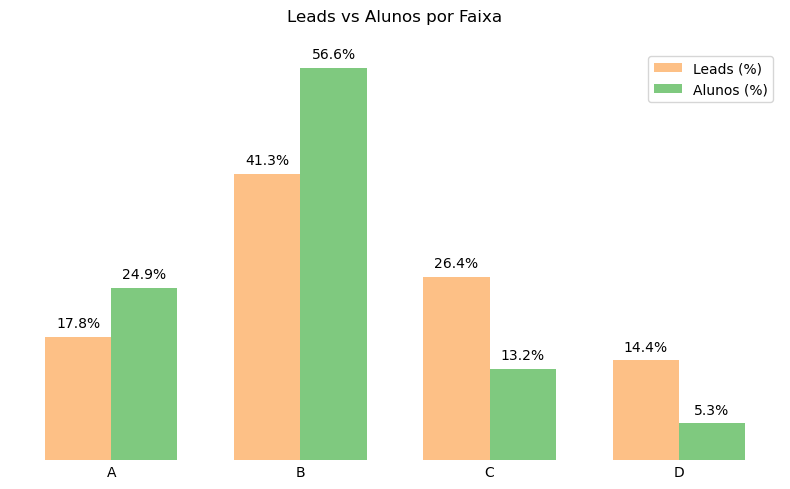

In [21]:
plot_comparativo_leads_alunos(df_leads, df_alunos)

In [22]:
# 1. Contagem por faixa
contagem = (
    df_leads.groupby(["lancamentos", "leadscore_faixa"], observed=True)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)
media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
L31,486,19.2,1147,45.4,611,24.2,284,11.2,618.43
L32,946,20.2,2148,45.9,1109,23.7,479,10.2,622.93
L33,418,17.9,984,42.1,629,26.9,307,13.1,608.52
L34,422,13.3,983,30.9,1010,31.7,767,24.1,565.64


In [23]:
# 1. Contagem por faixa
contagem = (
    df_alunos.groupby(["lancamentos", "leadscore_faixa"], observed=False)
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

# 2. Percentual por faixa
percentual = (
    contagem.div(contagem.sum(axis=1), axis=0).round(3) * 100
)
percentual = percentual.rename(columns={col: f"{col} (%)" for col in percentual.columns})

# 3. Média do leadscore final
media_score = (
    df_leads.groupby("lancamentos", observed=True)["leadscore_mapeado"]
    .mean()
    .round(2)
)

media_score.name = "leadscore_medio"

# 4. Combinar tudo
tabela_lancamentos = pd.concat([contagem, percentual, media_score], axis=1)

# 5. Organizar colunas em pares: A, A (%), B, B (%), ...
colunas = []
for faixa in ["A", "B", "C", "D"]:
    colunas.append(faixa)
    colunas.append(f"{faixa} (%)")
colunas.append("leadscore_medio")

tabela_lancamentos = tabela_lancamentos[colunas]

# 6. Exibir
display(tabela_lancamentos)


,A,A (%),B,B (%),C,C (%),D,D (%),leadscore_medio
lancamentos,,,,,,,,,
L31,15.0,24.6,35.0,57.4,9.0,14.8,2.0,3.3,618.43
L32,20.0,23.8,48.0,57.1,13.0,15.5,3.0,3.6,622.93
L33,12.0,27.3,24.0,54.5,3.0,6.8,5.0,11.4,608.52
L34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,565.64


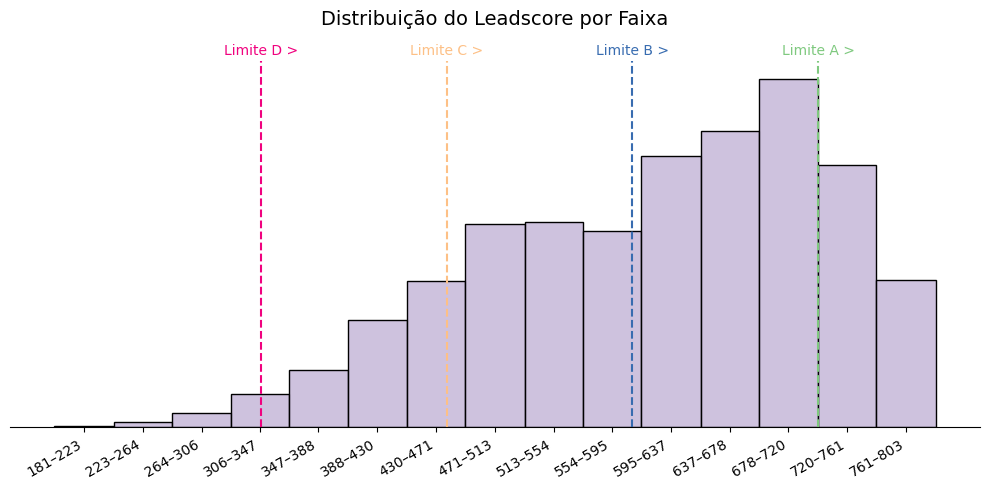

In [24]:
plot_histograma_leadscore(df_leads, limite_a, limite_b, limite_c, limite_d)

In [25]:
# Seleciona leads com faixa A ou B
leads_quentes = df_leads[df_leads["leadscore_faixa"].isin(["A", "B"])]
total_quentes = leads_quentes.shape[0]

# Quantos desses já compraram
compraram_quentes = leads_quentes["comprou"].sum()

# Resultado
print(f"Leads classificados como A ou B: {total_quentes}")
print(f"Desses, já compraram: {compraram_quentes}")
print(f"Ainda não compraram: {total_quentes - compraram_quentes}")

Leads classificados como A ou B: 7534
Desses, já compraram: 157
Ainda não compraram: 7377


# Modelo de Regressão

In [26]:
"""
Esse bloco monta um modelo de classificação binária para prever a probabilidade de conversão de leads, com:

- Entrada: Perfil e respostas do lead
- Saída: Chance de virar aluno
- Algoritmo: Gradient Boosting
- Métrica usada: ROC AUC
"""

features_leads = [
    "renda",
    "escolaridade",
    "idade",
    "estado_civil",
    "filhos", 
    "escolheu_profissao",
    "dificuldade"
]

# One-hot encoding
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Modelo
modelo_class = GradientBoostingClassifier(random_state=42)
modelo_class.fit(X_train, y_train)

# Avaliação
roc_auc = roc_auc_score(y_test, modelo_class.predict_proba(X_test)[:, 1])
print(f"ROC AUC (possível comprador): {roc_auc:.3f}")

# (Opcional) Score de probabilidade
df_leads["probabilidade_conversao_modelo"] = modelo_class.predict_proba(X)[:, 1]

ROC AUC (possível comprador): 0.484


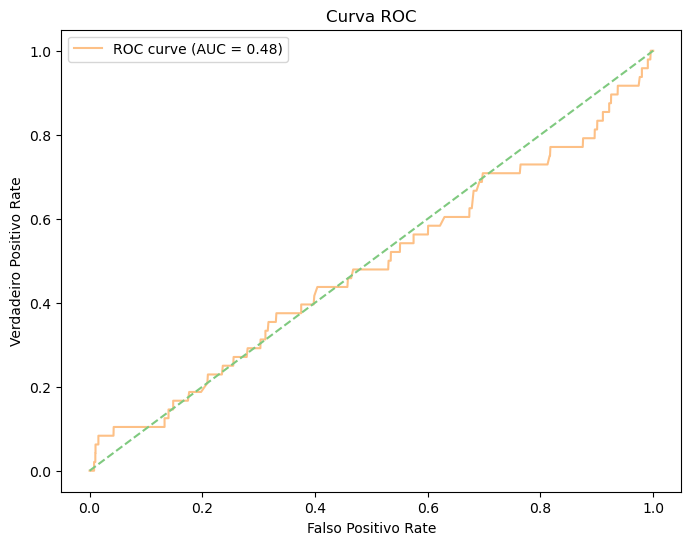

,Threshold,Precision,Recall,F1 Score
2,0.040816,0.057,0.083,0.068
0,0.000000,0.015,1.000,0.030
1,0.020408,0.015,0.271,0.029
3,0.061224,0.038,0.021,0.027
37,0.755102,0.000,0.000,0.000
28,0.571429,0.000,0.000,0.000
29,0.591837,0.000,0.000,0.000
30,0.612245,0.000,0.000,0.000
31,0.632653,0.000,0.000,0.000
32,0.653061,0.000,0.000,0.000


In [27]:
# Certifique-se de ter X_test, y_test e modelo treinado
probs = modelo_class.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plotar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, probs):.2f})", color=cores[2])
plt.plot([0, 1], [0, 1], linestyle="--", color=cores[0])
plt.xlabel("Falso Positivo Rate")
plt.ylabel("Verdadeiro Positivo Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(False)
plt.show()

# Avaliação para thresholds de 0.0 até 1.0
thresholds_to_test = np.linspace(0, 1, 50)
metrics = []

for thresh in thresholds_to_test:
    y_pred = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    metrics.append((thresh, precision, recall, f1))

# Mostrar tabela de avaliação
df_thresholds = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1 Score"])
df_thresholds["F1 Score"] = df_thresholds["F1 Score"].round(3)
df_thresholds["Precision"] = df_thresholds["Precision"].round(3)
df_thresholds["Recall"] = df_thresholds["Recall"].round(3)
df_thresholds.sort_values("F1 Score", ascending=False).head(10)

In [28]:
"""
Você poderá usar esse modelo para prever o score mesmo para leads que não constam no score_map ou para variáveis novas.
Também ajuda a testar consistência entre o modelo treinado e o score heurístico que você aplicou com base nos lifts.
"""

# Preparo dos dados
X_reg = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
y_reg = df_alunos["leadscore_mapeado"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, random_state=42)

# Modelo de regressão
modelo_reg = GradientBoostingRegressor(random_state=42)
modelo_reg.fit(X_train_r, y_train_r)

# Avaliação
y_pred_r = modelo_reg.predict(X_test_r)
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
mae_pct = (mae / y_test_r.mean()) * 100

print(f"R² (leadscore_mapeado): {r2:.2f}")
print(f"Erro médio absoluto (MAE): {mae:.2f}")
print(f"MAE percentual: {mae_pct:.2f}%")

R² (leadscore_mapeado): 0.97
Erro médio absoluto (MAE): 13.67
MAE percentual: 2.08%


In [29]:
# Previsão nos leads
X_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_leads = X_leads.reindex(columns=X_reg.columns, fill_value=0)

# Gerar leadscore estimado contínuo
df_leads["leadscore_regressao"] = modelo_reg.predict(X_leads).round(2)

# Visualizar os top leads por score estimado
df_leads.drop(columns=['email', 'whatsapp']).head(10)

,data,lancamentos,estado,idade,escolaridade,renda,estado_civil,filhos,escolheu_profissao,dificuldade,comprou,utm_source,utm_medium,utm_campaign,utm_content,utm_term,leadscore_mapeado,leadscore_faixa,probabilidade_conversao_modelo,leadscore_regressao
0,2025-01-27 17:31:57,L32,SP,26 - 35 anos,médio completo,de 3.000 a 5.000,união estável,sim,sonho de criança,falta de base escolar,0,whatsapp,grupos antigos,l32,None,None,663.91,B,0.034457,664.23
1,2024-11-20 10:56:47,L31,SP,46 - 55 anos,médio completo,até 1.000,divorciado(a) ou separado(a),sim,gosta da profissão,falta de oportunidade,0,instagram_feed,04_ll_1_envolvimento_30d,l31,video_vemai_v1,frio,586.17,C,0.001201,595.32
2,2025-01-28 01:45:29,L32,SP,26 - 35 anos,fundamental completo,desempregado,solteiro(a),não,sonho de criança,financeiro / dinheiro,0,tva,04_afinidade_luta,l32,video_5_motivos_yt,None,507.39,C,0.004854,534.21
3,2025-03-17 20:27:57,L33,SP,26 - 35 anos,médio completo,desempregado,solteiro(a),sim,sonho de criança,financeiro / dinheiro,0,instagram,bio,l33,None,None,669.12,B,0.007270,664.34
4,2025-03-23 22:39:51,L33,SP,26 - 35 anos,médio completo,de 1.000 a 3.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,0,instagram_stories,04_ll_10_lista_de_alunos,l33,video_vemai_v1_pag_f,frio,741.07,A,0.009251,719.98
5,2024-11-26 19:58:26,L31,RJ,46 - 55 anos,médio completo,até 1.000,solteiro(a),sim,gosta da profissão,financeiro / dinheiro,0,vadeos,comentarios,youtube,None,None,439.72,D,0.003428,336.09
6,2025-01-29 11:27:55,L32,SP,26 - 35 anos,superior completo,até 1.000,solteiro(a),não,estabilidade de emprego,falta de tempo,0,tva,04_mercado_concurso,l32,video_entrevista_v2_yt,None,480.85,C,0.004374,542.82
7,2025-02-02 10:47:03,L32,RJ,26 - 35 anos,médio completo,de 3.000 a 5.000,solteiro(a),sim,estabilidade de emprego,falta de tempo,0,instagram_feed,00_envolvimento_60d_seguidores,l32,imagem_sobral_1,quente,449.40,D,0.007941,439.16
8,2025-03-27 22:22:10,L33,SP,46 - 55 anos,médio completo,de 3.000 a 5.000,casado(a),não,estabilidade de emprego,falta de base escolar,0,instagram_feed,04_ll_10_lista_de_alunos,l33,video_vemai_v1,frio,647.74,B,0.034480,652.25
9,2024-12-01 12:07:58,L31,RJ,36 - 45 anos,médio completo,de 3.000 a 5.000,solteiro(a),sim,gosta da profissão,falta de oportunidade,0,instagram_stories,04_ll_10_lista_de_alunos,l31,imagem_sobral_1,frio,509.07,C,0.007623,470.10


In [30]:
# Validar se o modelo de regressão estima bem as faixas reais dos alunos

# 1. Copiar info de score real e faixa real
df_avaliacao = df_alunos[["email", "leadscore_mapeado", "leadscore_faixa"]].copy()

# 2. Gerar os X para regressão (features iguais às usadas no modelo)
X_alunos = pd.get_dummies(df_alunos[features_alunos], drop_first=False)
X_alunos = X_alunos.reindex(columns=X_reg.columns, fill_value=0)

# 3. Aplicar o modelo de regressão
df_avaliacao["leadscore_regressao"] = modelo_reg.predict(X_alunos)

# 4. Classificar usando a função baseada na média dos alunos
df_avaliacao["faixa_regressao"] = df_avaliacao["leadscore_regressao"].apply(classificar_faixa)

# 5. Ver a matriz de confusão real x predita
comparativo = df_avaliacao.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,45,2,0,0
B,0,106,1,0
C,0,1,24,0
D,0,0,1,9


In [31]:
# 1. Preparar X com mesmo shape
X_novos_leads = pd.get_dummies(df_leads[features_alunos], drop_first=False)
X_novos_leads = X_novos_leads.reindex(columns=X_reg.columns, fill_value=0)

# 2. Prever
df_leads["leadscore_regressao"] = modelo_reg.predict(X_novos_leads)

# 3. Classificar
df_leads["faixa_regressao"] = df_leads["leadscore_regressao"].apply(classificar_faixa)

comparativo = df_leads.groupby(["leadscore_faixa", "faixa_regressao"]).size().unstack(fill_value=0)

display(comparativo)

faixa_regressao,A,B,C,D
leadscore_faixa,,,,
A,1998,274,0,0
B,79,5128,55,0
C,0,411,2793,155
D,0,0,375,1462


In [32]:
# Juntar as bases
comparacao = df_leads.merge(
    df_alunos,
    on="email",
    suffixes=("_lead", "_aluno")
)

# Verificar onde as respostas foram diferentes
mudancas = {}
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Convertendo para string para evitar erro de comparação entre categoricals com categorias diferentes
        diferentes = (comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)).sum()
        total = comparacao.shape[0]
        mudancas[var] = round((diferentes / total) * 100, 1)
    else:
        mudancas[var] = None  # Ou 0, ou continue

# Transformar em DataFrame para exibição
df_mudancas = pd.DataFrame.from_dict(mudancas, orient="index", columns=["% Respostas Diferentes"])
df_mudancas = df_mudancas.dropna().sort_values(by="% Respostas Diferentes", ascending=False)

df_mudancas

,% Respostas Diferentes
renda,2.8
escolaridade,2.3
estado_civil,1.9
escolheu_profissao,1.9
idade,0.9
estado,0.0
filhos,0.0


In [33]:
# Para cada variável comum, mostrar diferenças
for var in features_alunos:
    col_lead = f"{var}_lead"
    col_aluno = f"{var}_aluno"
    
    if col_lead in comparacao.columns and col_aluno in comparacao.columns:
        # Comparação como string para evitar erros com categorias
        diferentes = comparacao[comparacao[col_lead].astype(str) != comparacao[col_aluno].astype(str)]
        total = comparacao.shape[0]

        print(f"\n🔍 {len(diferentes)} de {total} respostas são diferentes em '{var}'")
        display(diferentes[["email", col_lead, col_aluno]].head(10))
    else:
        print(f"\n⚠️ Coluna '{var}' não encontrada em ambos os DataFrames.")


🔍 0 de 213 respostas são diferentes em 'estado'


,email,estado_lead,estado_aluno



🔍 6 de 213 respostas são diferentes em 'renda'


,email,renda_lead,renda_aluno
64,fatimasantossantos429@gmail.com,desempregado,de 1.000 a 3.000
65,fatimasantossantos429@gmail.com,de 1.000 a 3.000,desempregado
79,frangochickenman@gmail.com,até 1.000,de 3.000 a 5.000
80,frangochickenman@gmail.com,de 3.000 a 5.000,até 1.000
211,kelsonwilliams239@gmail.com,até 1.000,de 1.000 a 3.000
212,kelsonwilliams239@gmail.com,até 1.000,de 1.000 a 3.000



🔍 5 de 213 respostas são diferentes em 'escolaridade'


,email,escolaridade_lead,escolaridade_aluno
113,junior.rega12@gmail.com,fundamental completo,médio completo
114,junior.rega12@gmail.com,médio completo,fundamental completo
117,kelsonwilliams239@gmail.com,fundamental completo,médio completo
118,kelsonwilliams239@gmail.com,médio completo,fundamental completo
211,kelsonwilliams239@gmail.com,médio completo,fundamental completo



🔍 2 de 213 respostas são diferentes em 'idade'


,email,idade_lead,idade_aluno
211,kelsonwilliams239@gmail.com,36 - 45 anos,26 - 35 anos
212,kelsonwilliams239@gmail.com,36 - 45 anos,26 - 35 anos



🔍 0 de 213 respostas são diferentes em 'filhos'


,email,filhos_lead,filhos_aluno



🔍 4 de 213 respostas são diferentes em 'estado_civil'


,email,estado_civil_lead,estado_civil_aluno
64,fatimasantossantos429@gmail.com,união estável,casado(a)
65,fatimasantossantos429@gmail.com,casado(a),união estável
211,kelsonwilliams239@gmail.com,solteiro(a),casado(a)
212,kelsonwilliams239@gmail.com,solteiro(a),casado(a)



🔍 4 de 213 respostas são diferentes em 'escolheu_profissao'


,email,escolheu_profissao_lead,escolheu_profissao_aluno
113,junior.rega12@gmail.com,sonho de criança,prestígio da carreira
114,junior.rega12@gmail.com,prestígio da carreira,sonho de criança
160,oficialviniciussiqueira@gmail.com,gosta da profissão,sonho de criança
161,oficialviniciussiqueira@gmail.com,sonho de criança,gosta da profissão


In [34]:
"""
Esse modelo é o coração da previsão de probabilidade de conversão. E ele tem duas grandes vantagens:

1. Calibração com pesos → ajuda a lidar com o desbalanceamento real
2. Integração com o score → junta perfil sociodemográfico + quão parecido o lead é com os alunos
"""

# Preparar X e y
X = pd.get_dummies(df_leads[features_leads], drop_first=False)
X["leadscore_mapeado"] = df_leads["leadscore_mapeado"]  # Adiciona o score final como feature
y = df_leads["comprou"]

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

modelo_calibrado = GradientBoostingClassifier(random_state=42)
modelo_calibrado.fit(X_train, y_train, sample_weight=sample_weight)

# Score calibrado com base nas duas fontes
df_leads["probabilidade_conversao_modelo"] = modelo_calibrado.predict_proba(X)[:, 1]

# Avaliação
print("ROC AUC:", roc_auc_score(y_test, modelo_calibrado.predict_proba(X_test)[:, 1]))
print(classification_report(y_test, modelo_calibrado.predict(X_test)))

ROC AUC: 0.5524920255183412
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      3135
           1       0.02      0.35      0.04        48

    accuracy                           0.71      3183
   macro avg       0.50      0.53      0.43      3183
weighted avg       0.97      0.71      0.82      3183



In [35]:
# Inicializar o scaler
scaler = MinMaxScaler()

# Normalizar os dois componentes separadamente
leadscore_normalizado = scaler.fit_transform(df_leads[["leadscore_regressao"]]).flatten()
probabilidade_normalizada = scaler.fit_transform(df_leads[["probabilidade_conversao_modelo"]]).flatten()

# Pesos (ajustáveis)
peso_score = 0.5
peso_prob = 0.5

# Calcular o score híbrido como média ponderada dos valores normalizados
df_leads["score_hibrido"] = (
    peso_score * leadscore_normalizado +
    peso_prob * probabilidade_normalizada
).round(4)

# Opcional: ordenar para inspeção
df_leads = df_leads.sort_values("score_hibrido", ascending=False)

# Exibir os 10 primeiros leads rankeados
display(df_leads[["email", "leadscore_regressao", "leadscore_faixa", "probabilidade_conversao_modelo", "score_hibrido"]].drop(columns=['email']).head(10))

,leadscore_regressao,leadscore_faixa,probabilidade_conversao_modelo,score_hibrido
10140,791.55047,A,0.695389,0.88
12562,791.55047,A,0.695389,0.88
8581,791.55047,A,0.695389,0.88
4517,791.55047,A,0.695389,0.88
3014,791.55047,A,0.695389,0.88
9036,791.55047,A,0.695389,0.88
4114,791.55047,A,0.695389,0.88
2161,791.55047,A,0.695389,0.88
820,791.55047,A,0.695389,0.88
3606,791.55047,A,0.695389,0.88


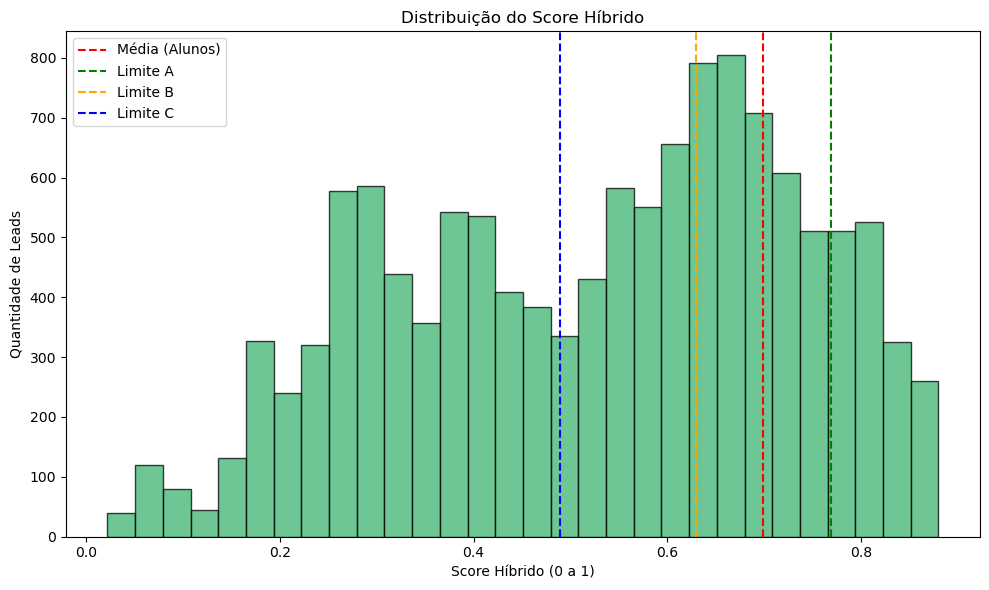

,Total Leads,Alunos,Taxa de Conversão (%)
faixa_score_hibrido,,,
A,1558,78,5.0%
B,3318,72,2.2%
C,2585,23,0.9%
D,5269,19,0.4%


In [36]:
# Base de referência: score_hibrido dos ALUNOS
media_hibrido_alunos = df_leads[df_leads["comprou"] == 1]["score_hibrido"].mean()

# Limiares baseados na média dos alunos
limite_A = media_hibrido_alunos * 1.10
limite_B = media_hibrido_alunos * 0.90
limite_C = media_hibrido_alunos * 0.70

# Função de classificação
def classificar_faixa_hibrida(score):
    if score >= limite_A:
        return "A"
    elif score >= limite_B:
        return "B"
    elif score >= limite_C:
        return "C"
    else:
        return "D"

# Aplicar a classificação
df_leads["faixa_score_hibrido"] = df_leads["score_hibrido"].apply(classificar_faixa_hibrida)

# Plotar histograma do score_hibrido
plt.figure(figsize=(10, 6))
plt.hist(df_leads["score_hibrido"], bins=30, color="mediumseagreen", edgecolor="black", alpha=0.75)
plt.axvline(media_hibrido_alunos, color="red", linestyle="--", label="Média (Alunos)")
plt.axvline(limite_A, color="green", linestyle="--", label="Limite A")
plt.axvline(limite_B, color="orange", linestyle="--", label="Limite B")
plt.axvline(limite_C, color="blue", linestyle="--", label="Limite C")

plt.title("Distribuição do Score Híbrido")
plt.xlabel("Score Híbrido (0 a 1)")
plt.ylabel("Quantidade de Leads")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# Gerar tabela de faixas com base na nova coluna faixa_score_hibrido
tabela_faixas_hibrido = (
    df_leads
    .groupby("faixa_score_hibrido")["comprou"]
    .agg(["count", "sum", "mean"])
    .rename(columns={
        "count": "Total Leads", 
        "sum": "Alunos", 
        "mean": "Taxa de Conversão"
    })
    .sort_index()
    .round(4)
)

# Formatar a taxa de conversão como string percentual
tabela_faixas_hibrido["Taxa de Conversão (%)"] = (
    tabela_faixas_hibrido["Taxa de Conversão"] * 100
).round(1).astype(str) + "%"

# Opcional: remover coluna bruta
tabela_faixas_hibrido = tabela_faixas_hibrido.drop(columns="Taxa de Conversão")

# Exibir resultado
display(tabela_faixas_hibrido)

In [37]:
# Calcular média do score híbrido por lançamento
media_hibrido_por_lancamento = (
    df_leads.groupby("lancamentos", observed=True)["score_hibrido"]
    .mean()
    .round(2)
    .reset_index()
    .rename(columns={"score_hibrido": "Probabilidade Relativa (0 - 1)"})
)

display(media_hibrido_por_lancamento)

,lancamentos,Probabilidade Relativa (0 - 1)
0,L31,0.54
1,L32,0.56
2,L33,0.53
3,L34,0.46


In [38]:
# Agrupamento por lançamento
tabela_lancamentos_avancada = df_leads.groupby("lancamentos", observed=True).agg(
    total_leads=("email", "count"),
    compras_reais=("comprou", "sum"),
    score_hibrido_medio=("score_hibrido", "mean"),
    probabilidade_media_modelo=("probabilidade_conversao_modelo", "mean"),
    taxa_real_conversao=("comprou", "mean")  # 0 = não comprou, 1 = comprou
).reset_index()

# Formatando colunas
tabela_lancamentos_avancada["score_hibrido_medio"] = tabela_lancamentos_avancada["score_hibrido_medio"].round(2)
tabela_lancamentos_avancada["probabilidade_media_modelo"] = (tabela_lancamentos_avancada["probabilidade_media_modelo"]).round(2)
tabela_lancamentos_avancada["taxa_real_conversao (%)"] = (tabela_lancamentos_avancada["taxa_real_conversao"] * 100).round(2)

# Selecionar colunas finais
tabela_lancamentos_avancada = tabela_lancamentos_avancada[[
    "lancamentos",
    "total_leads",
    "compras_reais",
    "taxa_real_conversao (%)",
    "probabilidade_media_modelo",
    "score_hibrido_medio"
]]

# Exibir resultado
display(tabela_lancamentos_avancada)

,lancamentos,total_leads,compras_reais,taxa_real_conversao (%),probabilidade_media_modelo,score_hibrido_medio
0,L31,2528,61,2.41,0.35,0.54
1,L32,4682,84,1.79,0.38,0.56
2,L33,2338,44,1.88,0.36,0.53
3,L34,3182,3,0.09,0.29,0.46


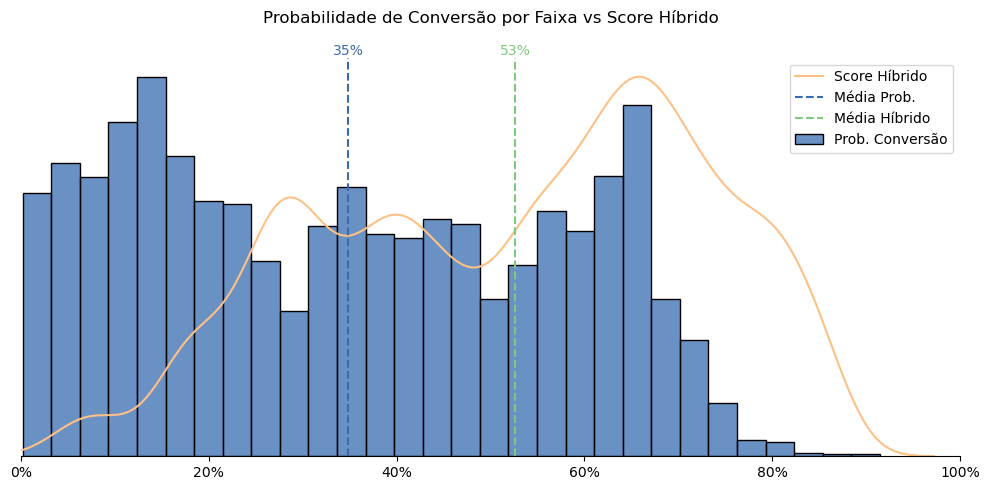

In [39]:
plot_probabilidade_conversao_vs_score(df_leads)

In [40]:
# Gerar a tabela cruzada real x predita com leads que viraram alunos
df_compare = df_leads[df_leads["email"].isin(df_alunos["email"])][["email", "faixa_score_hibrido"]]
df_compare = df_compare.merge(
    df_alunos[["email", "leadscore_faixa"]],
    on="email"
)

# Tabela cruzada: faixa real (aluno) vs faixa predita (modelo híbrido)
comparativo_faixa = pd.crosstab(df_compare["leadscore_faixa"], df_compare["faixa_score_hibrido"])

# Calcular Cramér’s V com essa matriz
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Calcular e imprimir
cramers_v_score = cramers_v(comparativo_faixa)
print(f"Cramér’s V: {cramers_v_score:.3f} (0 = sem associação, 1 = associação perfeita)")

Cramér’s V: 0.375 (0 = sem associação, 1 = associação perfeita)


In [41]:
# Caminho direto para a pasta 'modelos'
path_modelos = Path("C:/Users/Camilo_Bica/data_science/consultoria/escola_policia/modelos")
path_modelos.mkdir(parents=True, exist_ok=True)

# Média dos compradores (referência para benchmarking)
media_compradores = df_alunos["leadscore_mapeado"].mean()

# 1. Modelo de regressão para prever leadscore
joblib.dump(modelo_reg, path_modelos / "modelo_regressao_leadscore_total.pkl")
joblib.dump(X_reg.columns.tolist(), path_modelos / "colunas_regressao.pkl")

# 2. Limites para classificar em faixas A, B, C, D
limites = {
    "media_compradores": media_compradores,
    "limite_a": limite_a,
    "limite_b": limite_b,
    "limite_c": limite_c,
    "limite_d": limite_d
}
joblib.dump(limites, path_modelos / "limites_faixa.pkl")

joblib.dump(score_map, path_modelos / "score_map.pkl")

# 3. Modelo de classificação calibrado para prever conversão
joblib.dump(modelo_calibrado, path_modelos / "modelo_conversao_calibrado.pkl")
joblib.dump(X.columns.tolist(), path_modelos / "colunas_modelo_conversao_calibrado.pkl")

tabelas_lift = {}
for feature in features_alunos:
    tabela = gerar_tabela_lift_score_ponderado(df_leads, df_alunos, feature)
    tabelas_lift[feature] = tabela

joblib.dump(tabelas_lift, path_modelos / "tabelas_lift.pkl")

# 4. Confirmação
print("✅ Modelos e arquivos de configuração exportados para:", path_modelos)

✅ Modelos e arquivos de configuração exportados para: C:\Users\Camilo_Bica\data_science\consultoria\escola_policia\modelos


In [42]:
output_path = Path.cwd().parent / "dados"
df_leads.to_parquet(output_path / "leads_leadscore.parquet", index=False)
df_alunos.to_parquet(output_path / "alunos_leadscore.parquet", index=False)